In [1]:
!pip install --upgrade pandas
!pip install --upgrade matplotlib
!pip install --upgrade ipympl
!pip install --upgrade plotly.express
!pip install --upgrade ipython
!pip install --upgrade IPython
!pip install --upgrade scipy.interpolate


ERROR: Could not find a version that satisfies the requirement scipy.interpolate (from versions: none)
ERROR: No matching distribution found for scipy.interpolate


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import IPython
from scipy.interpolate import interp1d
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline


In [3]:
def massage_df(df, start_date, debug=False, maxO2=200):
    ## Date Time noralizing
    df['DateTime'] = df['DateTime'].dt.round('1s')

    # filter out older records
    certain_date = pd.to_datetime(start_date)  # Adjust the date as needed
    df = df[df['DateTime'] >= certain_date]

    ## convert to number
    df['O2'] = pd.to_numeric(df['O2'], errors='coerce')
    df['PR'] = pd.to_numeric(df['PR'], errors='coerce')

    # drop bad data
    df[df['O2'] > maxO2] = np.nan  # replace with NaN or any other value if needed
    nan_count = df.isna().sum(axis=0)
    nan_rows = df[df.isna().any(axis=1)]
    df.dropna(inplace=True)
    # if (debug): 
    #     print(f"Number of NaN values in viatom:\n{nan_count}")
    #     print(f"nan_rows={nan_rows}")

    # remove dupes
    df = df.sort_values('DateTime').drop_duplicates()

    # aggregate to nearest minute
    df['DateTime'] = df['DateTime'].dt.floor('min')  # 'T' stands for minute
    # Perform aggregation (e.g., taking the mean of 'Value' for each minute)
    df = df.groupby('DateTime')['O2'].mean().reset_index()

    # remove dupes
    df = df.sort_values('DateTime').drop_duplicates()

    df['dO2'] = df['O2'].diff().abs()
    df.dropna(inplace=True)
    df['dO2'] = df['dO2'].astype(int)

    if (debug):
        print(df.head())
        print(df.describe(include='all', percentiles=[.25, .5, .75, .90, .95, .99]))

    return df


In [4]:
def read_emay(start_date, debug=False, maxO2=200):
    df = pd.read_csv('emay.csv')
    
    ## renaming columns
    df.rename(columns={'SpO2(%)': 'O2'}, inplace=True)
    df.rename(columns={'PR(bpm)': 'PR'}, inplace=True)
    
    ## Date Time conversion
    df['DateTime'] = df['Date'].astype(str) + " " + df['Time'].astype(str)
    df.drop(columns=['Date', "Time"], inplace=True)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    
    return massage_df(df, start_date, debug, maxO2)


In [5]:
def read_viatom(start_date, debug=False, maxO2=200):
    df = pd.read_csv('viatom.csv')

    ## renaming columns
    df.rename(columns={'Oxygen Level': 'O2'}, inplace=True)
    df.rename(columns={'Pulse Rate': 'PR'}, inplace=True)

    ## Date Time conversion
    df['DateTime'] = pd.to_datetime(df['Time'], errors='coerce')

    #drop other columns
    df.drop(columns=['Motion', "O2 Reminder", "PR Reminder", "Time"], inplace=True)    
    return massage_df(df, start_date, debug, maxO2)


In [27]:
def plot_two(df1, df2, col='O2', name1="emay", name2="viatom"):
    plt.figure(figsize=(10, 6))  # Set the figure size

    plt.plot(df1['DateTime'], df1[col], label=name1, linestyle='', marker='.')
    plt.plot(df2['DateTime'], df2[col], label=name2, linestyle='', marker='.')
    
    plt.xlabel('DateTime')
    plt.ylabel('O2')
    plt.title('O2 Levels Over Time')
    plt.legend()  # Show legend with DataFrame names
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [7]:
# load the data frames
DEBUG = False
START_DATE = '2024-02-27'

In [15]:
# load the data frames
emay = read_emay(START_DATE, DEBUG)
print(emay.describe())
print(emay['O2'].value_counts(dropna=False))


                            DateTime           O2          dO2
count                           3445  3445.000000  3445.000000
mean   2024-03-03 16:03:22.815674880    93.121964     0.487373
min              2024-02-27 00:01:00    79.333333     0.000000
25%              2024-02-29 04:38:00    92.333333     0.000000
50%              2024-03-04 05:41:00    93.133333     0.000000
75%              2024-03-06 05:46:00    94.133333     1.000000
max              2024-03-09 06:54:00    97.750000    12.000000
std                              NaN     1.655984     1.122919
O2
93.000000    68
94.000000    31
93.116667    27
92.783333    26
95.000000    25
             ..
89.650000     1
90.350000     1
90.733333     1
88.616667     1
91.161290     1
Name: count, Length: 509, dtype: int64


/tmp/ipykernel_2621/3181156995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O2'] = pd.to_numeric(df['O2'], errors='coerce')
/tmp/ipykernel_2621/3181156995.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PR'] = pd.to_numeric(df['PR'], errors='coerce')
/tmp/ipykernel_2621/3181156995.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [16]:
viatom = read_viatom(START_DATE, DEBUG)
print(viatom.describe())
print(viatom['O2'].value_counts(dropna=False))


                            DateTime           O2          dO2
count                           3525  3525.000000  3525.000000
mean   2024-03-04 16:25:35.761702144    93.425102     0.372482
min              2024-02-27 22:53:00    84.866667     0.000000
25%              2024-03-01 03:37:00    92.400000     0.000000
50%              2024-03-05 04:40:00    93.400000     0.000000
75%              2024-03-07 16:01:00    94.533333     0.000000
max              2024-03-09 06:54:00    98.200000     9.000000
std                              NaN     1.691783     0.857949
O2
93.000000    95
94.000000    90
95.000000    89
92.933333    70
93.266667    68
             ..
91.642857     1
93.928571     1
88.400000     1
88.533333     1
90.500000     1
Name: count, Length: 183, dtype: int64


/tmp/ipykernel_2621/3181156995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O2'] = pd.to_numeric(df['O2'], errors='coerce')
/tmp/ipykernel_2621/3181156995.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PR'] = pd.to_numeric(df['PR'], errors='coerce')
/tmp/ipykernel_2621/3181156995.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

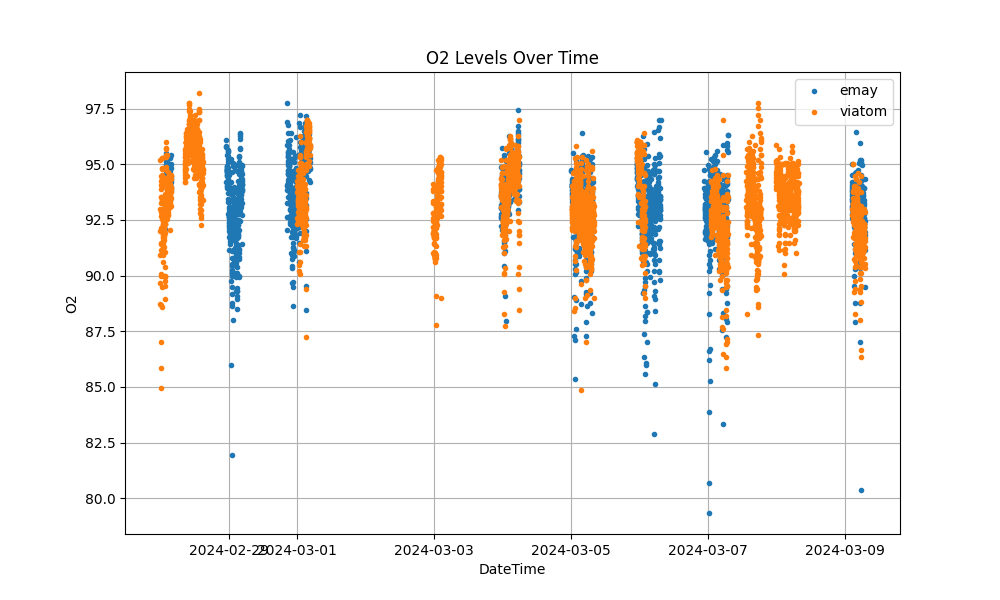

In [28]:
# plot them

threshold_date='2024-02-28'
filtered_emay = emay[emay['DateTime'] > threshold_date]
filtered_viatom = viatom[viatom['DateTime'] > threshold_date]

%matplotlib widget
plot_two(filtered_emay, filtered_viatom, 'O2')

In [11]:
!jupyter notebook --version


7.1.1


In [12]:
print(matplotlib.__version__)


3.8.3


In [13]:
print(IPython.__version__)
print(IPython.__version__)



8.22.2
8.22.2


In [14]:
!ipython --version

8.22.2
